In [1]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [2]:
llm.invoke("Hi").content

'Hi! 👋  How can I help you today?\n'

In [3]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [4]:
def call_model(state: MessagesState): #state - user input
    messages = state['messages'] #fetch the user input
    response = llm.invoke(messages) #pass the user input to the llm
    return {"messages": [response]} 

In [5]:
#Let's create a workflow
workflow = StateGraph(MessagesState) #workflow with state graph
#Add node
workflow.add_node("CHATBOT",call_model)
#Add edge
workflow.add_edge(START,"CHATBOT")
workflow.add_edge("CHATBOT",END)

app = workflow.compile()


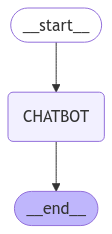

In [6]:
#Visualize the workflow

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
input = {"messages": [HumanMessage("Hi, my name is Amar")]}

#or

#input = {"messages": ["Hi, my name is Amar"]}

In [8]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, my name is Amar', additional_kwargs={}, response_metadata={}, id='2417781a-1b5b-4c78-885c-c84db467ffe5'),
  AIMessage(content='Hello Amar, nice to meet you! 👋\n\nWhat can I do for you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 15, 'total_tokens': 37, 'completion_time': 0.04, 'prompt_time': 9.207e-05, 'queue_time': 0.01919924, 'total_time': 0.04009207}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-66c36404-ec5a-4191-9c02-213fdcb7330a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 22, 'total_tokens': 37})]}

In [9]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node") #Key representing the node
        print("_______")
        print(value) #value representing the actual output
        print("\n") 

Output from CHATBOT Node
_______
{'messages': [AIMessage(content="Hello Amar, it's nice to meet you! 👋 \n\nWhat can I do for you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 7.492e-05, 'queue_time': 0.02232581, 'total_time': 0.047347647}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f07d8043-7562-4f88-9bbe-bba53ed285be-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}




In [31]:
#Second Stage with architecture 2
# Here we are going to add the tools inside our solution

#Let's create a tool(Dummy tool)   
@tool
def search(query: str):
    """this is my custom tool."""
    if "ca" in query.lower() or "california" in query.lower():
        return "It's 20*C degrees and Cold."
    return "It's 40*C degrees and scootching heat."

In [32]:
search.invoke("what is the weather in CALIFORNIA?")

"It's 20*C degrees and Cold."

In [33]:
search.invoke("what is the weather in CA?")

"It's 20*C degrees and Cold."

In [34]:
search.invoke("what is the weather in ca?")

"It's 20*C degrees and Cold."

In [36]:
search.invoke("what is the weather in Texas?")

"It's 40*C degrees and scootching heat."

In [37]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001D557E85090>)

In [38]:
#Create the tool variable
tools = [search]

In [40]:
#Convert the tool to node
#tool_node = ToolNode("SEARCH",tools)

tool_node = ToolNode(tools)

In [41]:
#Let's bind our tool on top of the LLM and now our LLM will associated with our tool
llm_with_tool = llm.bind_tools(tools)

In [ ]:
#Create the workflow
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages) #Here we pass the input to the llm_with_tool(llm ond our own tool)
    return {"messages": [response]}